### The central visible galaxies change the velocities of the surrounding invisible matter in dark matter halos even far from center.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys, json, os
sys.path.append('..')
from project.constants import Constants as pc
from project.recoil import Nuclear as Nr
from project.recoil import get_vdf_ert, norm , p50
import pickle

import warnings
warnings.filterwarnings("ignore", message="Attempt to set non-positive ylim on a log-scaled axis will be ignored.")

In [2]:
MW_dict = pickle.load(open('../Output/MW_dict.pkl','rb'))
mwd = MW_dict['vdf_RCfit']

# 1. Find the Benchmark scenario ($m,\, \sigma_p,\, E_\mathrm{thr},\, \omega)$

In [3]:
ng = 100
Mdm = np.logspace(0, 1, ng)
Sdm = np.logspace(-48, -44, ng)
Mgrid, Sgrid = np.meshgrid(Mdm, Sdm)
blgrid = np.ones(Mgrid.shape)*0

nr1 = Nr('Xe', vE=mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']), 
         vcirc=p50(mwd['vcircs']), Eroi=5.0, Ethr=1.0, ω=1.0, 
         rhosun=p50(mwd['rhosuns']))

nr10 = Nr('Xe', vE=mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']), 
         vcirc=p50(mwd['vcircs']), Eroi=5.0, Ethr=0.1, ω=10.0, 
         rhosun=p50(mwd['rhosuns']))

N1 = nr1.totNgrid(Mgrid, Sgrid, blgrid)
N10 = nr10.totNgrid(Mgrid, Sgrid, blgrid)

S1, S10 = nr1.σpMdmNsg(Mdm), nr10.σpMdmNsg(Mdm)

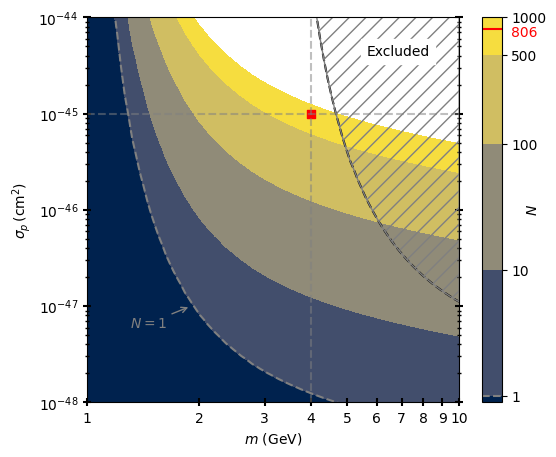

In [4]:
fig, ax = plt.subplots(figsize = (6,5))

ax.plot(Mdm, S1, c = 'k', ls = '--')
ax.fill_between(Mdm, S1, np.ones(Mdm.shape)*1e-40, color = 'grey', hatch = '//', facecolor = 'None',zorder = 2)
ax.text(0.75, 0.9, 'Excluded', backgroundcolor = 'white', transform = ax.transAxes)

cn = ax.contourf(Mgrid, Sgrid, N10, levels = [0, 1, 10, 100, 500, 1000], norm = "log", cmap = 'cividis')
cbar = fig.colorbar(cn, format = '%i')
ax.plot(Mdm, S10, c = 'grey', ls = '--')

ax.set_xlabel('$m$ (GeV)')
ax.set_ylabel('$\sigma_p \, (\mathrm{cm}^2)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-48, 1e-44)

ax.set_xticks([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]);
ax.tick_params(axis = 'both', which = 'both', right = True, left = True, direction = 'inout')
ax.tick_params(which = 'major', width = 1.5, length = 6)
ax.tick_params(which = 'minor', width = 1, length = 3)

m,sp = 4, 1e-45

ax.scatter(m, sp, c = 'r', marker = 's', s = 30)
ax.plot([m,m],[1e-48,1e-44], c = 'grey', ls = '--', alpha = 0.5)
ax.plot([1,10], [sp,sp], c = 'grey', ls = '--', alpha = 0.5);

Ntot = nr10.totNtot(m, sp)

cbar.ax.plot([0, 1], [Ntot, Ntot], color='red', linewidth=1.5)
cbar.ax.plot([0, 1], [1, 1], color='grey', linewidth=1.5, ls = '--')
cbar.ax.text(1.5, Ntot-100, '%i'%Ntot, color = 'r')
cbar.set_label('$N$', labelpad = -15)

ax.annotate('$N = 1$', xy=(1.9, 1e-47), xytext=(1.3, 6e-48), color = 'grey',
            arrowprops=dict(arrowstyle='->',color = 'grey'));

# plt.savefig('../Output/figures/nuclear/Exclusion_limit.png', bbox_inches = 'tight', dpi = 300)

# 2. Create mock data

## (i) Without background

In [5]:
nr = Nr('Xe',vE= mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']),
        vcirc=p50(mwd['vcircs']), rhosun=p50(mwd['rhosuns']), Ethr=0.1,
        Eroi=5.0, ω=10.0)
m, sp = 4.0, 1e-45
bins = np.linspace(0.1, 5, 50)

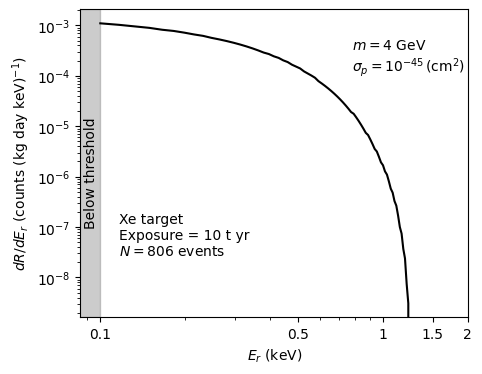

In [6]:
fig, ax = plt.subplots(figsize = (5,4))

ax.plot(nr.E, nr.diffSg(m, sp), c = 'k')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.085,2)
ylim = ax.get_ylim()

ax.fill_betweenx(ylim, 0.1, 0, color = 'grey', alpha = 0.4)
ax.text(0.01, 0.3, 'Below threshold', size = 10, rotation = 90, transform = ax.transAxes)
ax.set_ylim(ylim)

ax.set_xlabel('$E_r$ (keV)')
ax.set_ylabel('$dR/dE_r$ (counts (kg day keV)$^{-1}$)')
ax.set_xticks([0.1, 0.5, 1, 1.5, 2], [0.1, 0.5, 1, 1.5, 2])

ax.text(0.7, 0.8, '$m = 4$ GeV \n$\sigma_p = 10^{-45} \, (\mathrm{cm}^2)$', transform = ax.transAxes)
ax.text(0.1, 0.2, f'Xe target \nExposure = 10 t yr \n$N = {int(nr.totNtot(m, sp))}$ events', transform = ax.transAxes);

# plt.savefig('../Output/figures/nuclear/Differential_recoil_sg.png',bbox_inches = 'tight', dpi = 300)

Text(0, 0.5, '# events')

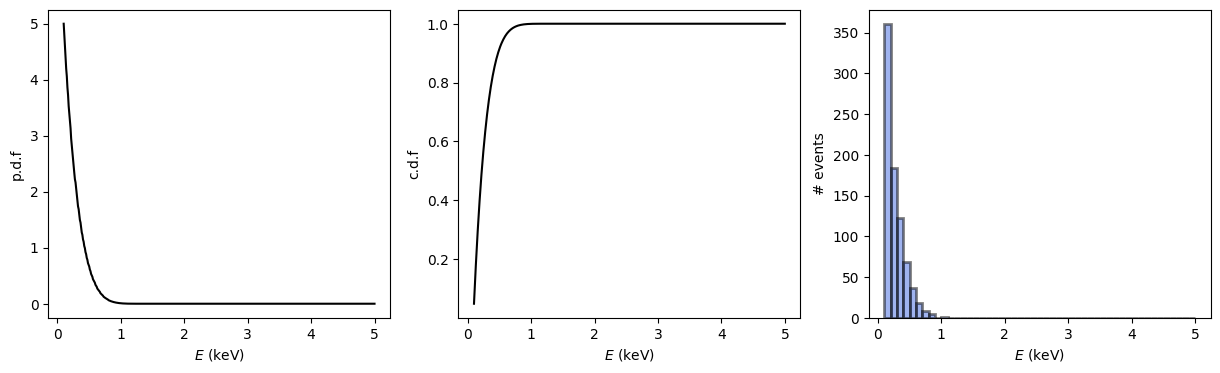

In [8]:
sampd = nr.mocksample(m, sp, bl=0.)

fig, axs = plt.subplots(1,3, figsize = (15,4))
ax1, ax2, ax3 = axs

ax1.plot(sampd['E_array'], sampd['pdf'], c = 'k')
ax2.plot(sampd['E_array'], sampd['cdf'], c = 'k')
ax3.hist(sampd['Esample'], bins = bins, color = 'royalblue', histtype = 'bar', lw = 2, alpha = 0.5, edgecolor = 'k');

for ax in axs:
    ax.set_xlabel('$E$ (keV)')
    # ax.set_xlim(0, 2)
ax1.set_ylabel('p.d.f')
ax2.set_ylabel('c.d.f')
ax3.set_ylabel('# events')

# plt.savefig('../Output/figures/nuclear/mock_samples.png', bbox_inches = 'tight', dpi = 300)

## (ii) With constant background

In [3]:
nrb = Nr('Xe', vE=mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']),
         vcirc=p50(mwd['vcircs']), rhosun=p50(mwd['rhosuns']), Ethr=0.1,
         Eroi=5.0, ω=10.0)
bins = np.linspace(0.1, 5, 50)

In [ ]:
fig, ax = plt.subplots(figsize = (5,4))

ax.plot(nr.E, nr.diffTot(m, sp, bl = 1), c = 'r')
# ax.plot(nr.E, nr.diffTot(m, sp, bl = 0), c = 'k', ls = '--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.085,2)

ylim = ax.get_ylim()
ax.fill_betweenx(ylim, 0.1, 0, color = 'grey', alpha = 0.4)
ax.set_ylim(ylim)
ax.text(0.01, 0.3, 'Below threshold', size = 10, rotation = 90, transform = ax.transAxes)

ax.set_xlabel('$E_r$ (keV)')
ax.set_ylabel('$dR/dE_r$ (counts (kg day keV)$^{-1}$)')
ax.text(0.7, 0.8, '$m = 4$ GeV \n$\sigma_p = 10^{-45} \, (\mathrm{cm}^2)$', transform = ax.transAxes)
ax.text(0.1, 0.2, f'Xe target \nExposure = 10 t yr \n$N = {int(nrb.totNsg(m, sp))}$ events', transform = ax.transAxes)

ax.set_xticks([0.1, 0.5, 1, 1.5, 2], [0.1, 0.5, 1, 1.5, 2]);

# plt.savefig('../Output/figures/nuclear/Differential_recoil_bg.png',bbox_inches = 'tight', dpi = 300)

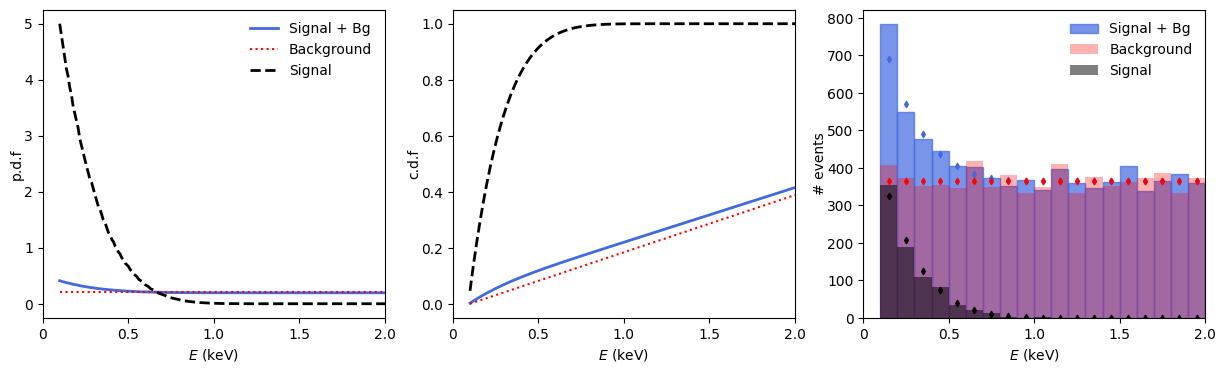

In [19]:
sp = 1e-45
bins = np.linspace(0.1, 5.0, 50)
sampd = nrb.mocksample(m, sp, Ntot = 'mean', bl = 0.001, seed = 5111)
samp = sampd['Esample']
E = sampd['E_array']

fig, axs = plt.subplots(1,3, figsize = (15,4))
ax1, ax2, ax3 = axs

ax1.plot(E, norm(sampd['pdf'], E), c = 'royalblue', lw = 2, label='Signal + Bg')
ax2.plot(E, sampd['cdf'], c = 'royalblue', lw = 2)
ax3.hist(samp, bins = bins, color = 'royalblue', histtype = 'bar', lw = 1, alpha = 0.7,  edgecolor = 'royalblue', label = 'Signal + Bg');

bd = nrb.mocksample(0, sp, bl = 0.001)
ax1.plot(bd['E_array'], norm(bd['pdf'], E), c = 'r', ls = ':', label = 'Background')
ax2.plot(bd['E_array'], bd['cdf'], c = 'r', ls = ':')
ax3.hist(bd['Esample'], bins = bins, color = 'r', histtype = 'bar', lw = 2, alpha = 0.3, label = 'Background');

sd = nrb.mocksample(m, sp, bl = 0.)
ax1.plot(sd['E_array'], norm(sd['pdf'], E), c = 'k', ls = '--', lw = 2, label='Signal')
ax2.plot(sd['E_array'], sd['cdf'], c = 'k', ls = '--', lw = 2)
ax3.hist(sd['Esample'], bins = bins, color = 'k', histtype = 'bar', alpha = 0.5, label = 'Signal')

ax1.legend(framealpha = 0)
ax3.legend(framealpha = 0)


for ax in axs:
    ax.set_xlabel('$E$ (keV)')
    ax.set_xlim(0, 2)
    ax.set_xticks([0,0.5,1.0,1.5,2.0], [0,0.5,1.0,1.5,2.0])
    
ax1.set_ylabel('p.d.f', labelpad = 0)
ax2.set_ylabel('c.d.f', labelpad = 0)
ax3.set_ylabel('# events', labelpad = 0)

bint = nrb.binTot(m, sp, 0.001, bin_edges = bins)
ax3.scatter(bint['E_center'], bint['Neachbin'], c= 'royalblue', marker = 'd', s = 10)
bint = nrb.binTot(0, sp, 0.001, bin_edges = bins)
ax3.scatter(bint['E_center'], bint['Neachbin'], c= 'r', marker = 'd', s = 10)
bint = nrb.binTot(m, sp, 0, bin_edges = bins)
ax3.scatter(bint['E_center'], bint['Neachbin'], c= 'k', marker = 'd', s = 10)

# plt.savefig('../Output/figures/nuclear/mock_samples_bg.png', bbox_inches = 'tight', dpi = 300)

## (iii) A potential problem?

In [ ]:
from tqdm.notebook import tqdm
size = 1000

E0bin = np.linspace(0.1, 0.2, 10)
λ0_poiss = np.random.poisson(nrb.totNtot(m, sp, 0.001, E=E0bin), size=size)
λ0_fmock = []
for i in tqdm(range(size)):
    sd = nrb.mocksample(m, sp, 0.001, Ntot = 'mean')
    hist = np.histogram(sd['Esample'], bins = np.linspace(0.1, 5.0, 50))
    λ0_fmock.append(hist[0][0])

In [ ]:
fig,ax = plt.subplots(figsize=(5,4))

ax.hist(λ0_fmock, bins = 20, color = 'red', density = True, alpha = 0.5, edgecolor = 'k', label = 'from 1000 mocks')
ax.hist(λ0_poiss, bins = 20, color = 'skyblue', density = True, alpha = 0.5, edgecolor = 'k', label = 'Poisson(expected $0^\mathrm{th}$ bin counts) ')

ax.legend(framealpha = 0, loc = 'upper left', labelspacing = 0.2)
ax.set_ylim(0,0.02)
ax.set_yticks([0,0.005, 0.010, 0.015, 0.02], [0,0.005,'0.010',0.015,"0.020"])

ax.set_xlabel('Number of counts in the frist bin')
ax.set_ylabel('Distribution')

# plt.savefig('../Output/figures/nuclear/First_bin_count_prob.png', bbox_inches = 'tight', dpi = 300)

# 3. Profile likelihood with background level ($b_l$) as nuicance parameter ($\nu$)

In [4]:
mocksample = nrb.mocksample(mdm=4., σp=1e-45, bl=0.001, seed=5111)

In [5]:
from project.recoil import ProfileLikelihood

pfl = ProfileLikelihood(nr=nrb, sample_dict=mocksample)

## (i) Using spcipy.optimize.minimize

In [13]:
from scipy.optimize import minimize
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore', message = 'invalid value encountered in log')

Ngrid = 100
Mdm = np.logspace(0, 1, Ngrid)
Sdm = np.logspace(-46, -44, Ngrid)

Mgrid, Sgrid = np.zeros([Ngrid]*2), np.zeros([Ngrid]*2)
LL = np.zeros([Ngrid, Ngrid])
BL = np.zeros([Ngrid, Ngrid])
for i,mdm in tqdm(enumerate(Mdm)):
    for j,sdm in enumerate(Sdm):
        pfl.mdm_sdm(mdm=mdm, σp=sdm)
        bl = minimize(pfl.nllike, x0 = 1e-3).x[0]
        BL[i,j] = bl
        LL[i,j] = pfl.nllike(bl)
        Mgrid[i,j] = mdm
        Sgrid[i,j] = sdm

0it [00:00, ?it/s]

Text(0, 0.5, '$\\sigma_p \\, (\\mathrm{cm}^2)$')

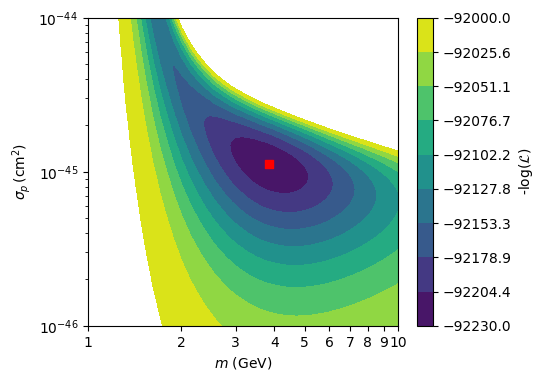

In [47]:
fig,ax = plt.subplots(figsize=(5,4))

ll_levels = np.linspace(-9.223e4, -9.2e4, 10)
cf = ax.contourf(Mgrid, Sgrid, LL, levels = ll_levels, cmap = 'viridis',norm = 'linear')
cb = fig.colorbar(cf, label = '-log($\mathcal{L}$)')

indx = np.where(LL == np.min(LL))
ax.scatter(Mgrid[indx], Sgrid[indx], c='r', marker='s')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10])

ax.set_xlabel('$m$ (GeV)')
ax.set_ylabel('$\sigma_p \, (\mathrm{cm}^2)$')

# plt.savefig('../Output/figures/nuclear/Likelihood_bl.png',bbox_inches = 'tight', dpi = 300)

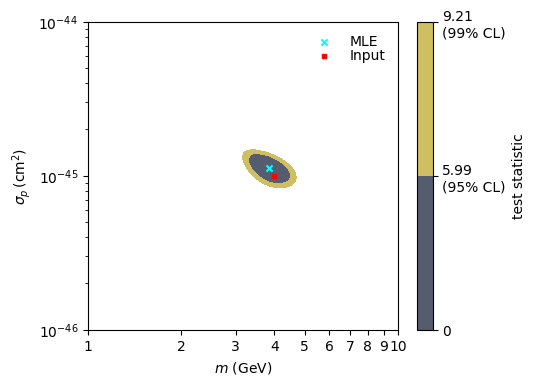

In [48]:
fig,ax = plt.subplots(figsize=(5,4))

tq = LL - np.min(LL)
tq_levels = [0.,5.99,9.21]
cf = ax.contourf(Mgrid, Sgrid, tq, levels=tq_levels, cmap='cividis', norm='linear')
cb = fig.colorbar(cf, label='test statistic')

indx = np.where(LL == np.min(LL))
ax.scatter(Mgrid[indx], Sgrid[indx], c='cyan', marker='x', s = 20, label='MLE')
ax.scatter(4., 1e-45, c='r', marker='s', s = 10, label='Input')
ax.legend(frameon=False,labelspacing=0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10])
cb.set_ticklabels(['0', '5.99\n(95% CL)', '9.21\n(99% CL)'])

ax.set_xlabel('$m$ (GeV)')
ax.set_ylabel('$\sigma_p \, (\mathrm{cm}^2)$');

# plt.savefig('../Output/figures/nuclear/test_statistic_bl.png', bbox_inches = 'tight', dpi = 300)

In [49]:
# nr_dict = {'key1': {'Mdm': Mdm,
#                     'Sdm': Sdm,
#                     'Mgrid': Mgrid,
#                     'Sgrid': Sgrid,
#                     'LL': LL,
#                     'BL': BL,
#                     'pdf': pfl,
#                     'll_levels': ll_levels,
#                     'min_indx': indx,
#                     'tq': tq,
#                     'll_min': np.min(LL),
#                     'tq_levels': tq_levels,
#                     'best_mdm': Mgrid[indx],
#                     'best_sdm': Sgrid[indx]}}
# import pickle
# pickle.dump(nr_dict, open('../Output/nuclear_dict.pkl','wb'))

## (ii) Using iminuit

In [60]:
from iminuit import Minuit
import project.quadrantHopping as quadH
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore', message = 'invalid value encountered in log')

Ngrid = 50
Mdm = np.logspace(0, 1, Ngrid)
Sdm = np.logspace(-46, -44, Ngrid)

Mgrid, Sgrid = np.zeros([Ngrid]*2), np.zeros([Ngrid]*2)
LL = np.zeros([Ngrid, Ngrid])
BL = np.zeros([Ngrid, Ngrid])
for i,mdm in tqdm(enumerate(Mdm)):
    for j,sdm in enumerate(Sdm):
        pfl.mdm_sdm(mdm=mdm, σp=sdm)

        bl_guess = 0.001
        m = Minuit(pfl.nllike, bl = bl_guess)
        m.limits['bl'] = (1e-5, 1e-1)
        m.errordef = Minuit.LIKELIHOOD
        min_res,m = quadH.quadhop(m, ['bl'], [bl_guess])
        
        BL[i,j] = min_res['globalmin'][0]
        LL[i,j] = min_res['globalfun']
        Mgrid[i,j] = mdm
        Sgrid[i,j] = sdm

0it [00:00, ?it/s]

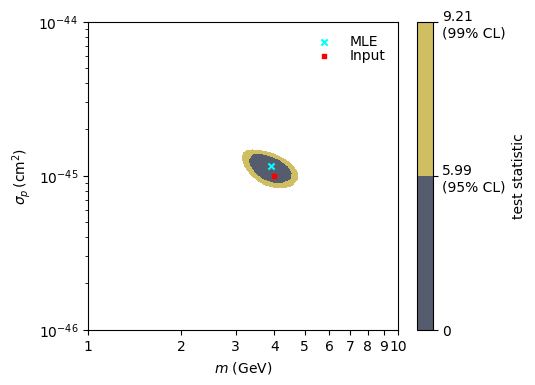

In [61]:
fig,ax = plt.subplots(figsize=(5,4))

tq = LL - np.min(LL)
tq_levels = [0.,5.99,9.21]
cf = ax.contourf(Mgrid, Sgrid, tq, levels=tq_levels, cmap='cividis', norm='linear')
cb = fig.colorbar(cf, label='test statistic')

indx = np.where(LL == np.min(LL))
ax.scatter(Mgrid[indx], Sgrid[indx], c='cyan', marker='x', s = 20, label='MLE')
ax.scatter(4., 1e-45, c='r', marker='s', s = 10, label='Input')
ax.legend(frameon=False,labelspacing=0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10])
cb.set_ticklabels(['0', '5.99\n(95% CL)', '9.21\n(99% CL)'])

ax.set_xlabel('$m$ (GeV)')
ax.set_ylabel('$\sigma_p \, (\mathrm{cm}^2)$');

## (iii) Finding global min using iminuit (including $m$ and $\sigma_p$)

In [ ]:
minf, minp = pfl.nll_blmdsp_min()

(5e-46, 3e-45)

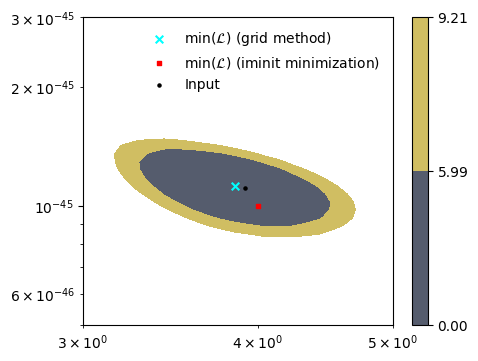

In [32]:
import pickle

nrd = pickle.load(open('../Output/nuclear_dict.pkl','rb'))['key1']

fig,ax = plt.subplots(figsize = (5,4))

cf = ax.contourf(nrd['Mgrid'], nrd['Sgrid'], nrd['tq'], levels=nrd['tq_levels'], cmap='cividis')
cb = fig.colorbar(cf)

ax.scatter(nrd['best_mdm'], nrd['best_sdm'], c='cyan', marker='x', s=30, label='min($\mathcal{L}$) (grid method)')
ax.scatter(4., 1e-45, c='r', marker='s', s=10, label='min($\mathcal{L}$) (iminit minimization)')
ax.scatter(minp[0], minp[1], c = 'k', s = 5, zorder=2, label='Input')
ax.legend(frameon=False)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(3,5)
ax.set_ylim(5e-46,3e-45)

# 4. Monte carlo for $\Delta m_\mathrm{stat}$

In [45]:
from tqdm.notebook import tqdm
from project.recoil import ProfileLikelihood
from multiprocessing import Pool, cpu_count
from datetime import datetime

nrb = Nr('Xe', vE=mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']), vcirc=p50(mwd['vcircs']), rhosun=p50(mwd['rhosuns']), Ethr=0.1, Eroi=5.0, ω=10.0)

Mdm = np.linspace(2.5, 5.5, 100)
Sdm = np.logspace(-46,-44, 100)

mocksample = nrb.mocksample(4., 1e-45, 0.001,
                                Ntot='poisson',
                                seed=0)
nrb.binTot_mdm_array(bin_edges=mocksample['E_bins'],
                         Mdm = Mdm)

Nmocks = 1000
np.random.seed(seed=999)
seeds = np.random.randint(low=1000, high=10000, size=Nmocks)

def func(idx):
    # print (f'{idx} begins at {datetime.now().strftime("%H:%M:%S")}\n')
    seed = seeds[idx]
    res_dict = {}
    mocksample = nrb.mocksample(4., 1e-45, 0.001,
                                Ntot='poisson',
                                seed=seed)
    pfl = ProfileLikelihood(nrb, mocksample)
    Mgrid, Sgrid, bl_min, ll_min = pfl.nll_bl(Mdm=Mdm,
                                              Sdm=Sdm)
    indx = np.where(ll_min == np.min(ll_min))
    res_dict['mocksample'] = mocksample
    res_dict['pfl'] = pfl 
    res_dict['mdm'] = Mgrid[indx]
    res_dict['sdm'] = Sgrid[indx]
    res_dict['indx'] = indx
    res_dict['ll_min'] = ll_min
    res_dict['bl_min'] = bl_min
    res_dict['idx'] = idx
    res_dict['seed'] = seed
    return res_dict

def parallel_process(Idx):
    num_cores = cpu_count()
    print (f'process running in {num_cores} cores (total iterations {len(Idx)})')
    with Pool(processes=num_cores) as pool:
        results = list(tqdm(pool.imap(func, Idx), total=len(Idx)))
    return results

results = parallel_process(np.arange(Nmocks))

process running in 8 cores (total iterations 1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

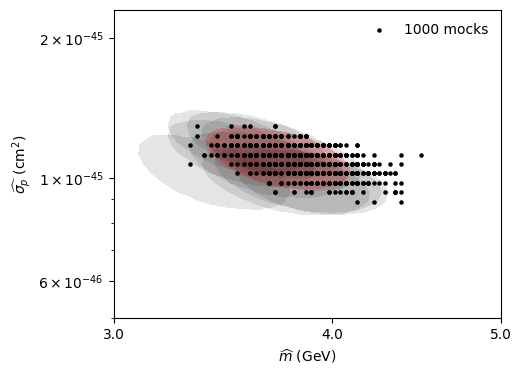

In [53]:
fig,ax = plt.subplots(figsize = (5,4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(3, 5)
ax.set_ylim(5e-46,2.3e-45)

for i in range(Nmocks):
    res = results[i]
    ll = res['pfl'].ll_min
    tq = 2*(ll - np.min(ll))
    if i <= 10:
        color,z,a = ('r',2,0.2) if i == 0 else ('k',0,0.1)
        ax.contourf(pfl.Mgrid, pfl.Sgrid, tq, levels = [0,6], colors = color, alpha=a, zorder=z)
    sc = ax.scatter(res['mdm'], res['sdm'], c= 'k', s=5,zorder = 2)

# ax.scatter(pfl.Mgrid, pfl.Sgrid, np.ones(pfl.Mgrid.shape), alpha=0.2)
ax.legend(handles=[sc], labels=[f'{Nmocks} mocks'], frameon=False)

ax.set_xlabel('$\widehat{m}$ (GeV)')
ax.set_ylabel('$\widehat{\sigma_p} \,\, (\mathrm{cm}^2)$')
ax.set_xticks([3,4,5],[3.0,4.0,5.0])
ax.set_yticks([6e-46, 1e-45, 2e-45], [r'$6\times10^{-46}$', r'$1\times10^{-45}$', r'$2\times10^{-45}$']);
# plt.savefig('../Output/figures/nuclear/Mock_vs_pfl.png',bbox_inches = 'tight', dpi = 300)